<a href="https://colab.research.google.com/github/Sibahle01/Ai--Dairy-Free-Your-Mind/blob/main/Ai_Dairy%2C_Free_Your_Mind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core libraries
import sqlite3
import pandas as pd
from json import dumps, loads
from dataclasses import dataclass
from typing import Optional, Dict, List, Any
import logging
import time
import traceback

# NLP
from transformers import pipeline

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#2️⃣ Database Setup

In [ ]:
# Initialize SQLite DB
conn = sqlite3.connect("diary.db")
cursor = conn.cursor()

cursor.executescript("""
CREATE TABLE IF NOT EXISTS users (
    user_id INTEGER PRIMARY KEY AUTOINCREMENT,
    username TEXT NOT NULL UNIQUE,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

CREATE TABLE IF NOT EXISTS entries (
    entry_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    entry_text TEXT NOT NULL,
    main_category TEXT NOT NULL,
    secondary_category TEXT,
    sub_category TEXT,
    confidence_scores TEXT,
    success BOOLEAN NOT NULL DEFAULT 1,
    error_message TEXT,
    processing_time REAL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

CREATE TABLE IF NOT EXISTS goals (
    goal_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    entry_id INTEGER, -- optional link to diary entry where goal was mentioned
    goal_text TEXT NOT NULL,
    status TEXT DEFAULT 'pending', -- pending | in-progress | completed
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    completed_at TIMESTAMP,
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (entry_id) REFERENCES entries(entry_id)
);

CREATE TABLE IF NOT EXISTS tags (
    tag_id INTEGER PRIMARY KEY AUTOINCREMENT,
    entry_id INTEGER NOT NULL,
    tag TEXT NOT NULL,
    FOREIGN KEY (entry_id) REFERENCES entries(entry_id)
);
""")
conn.commit()
conn.close()

#3️⃣ Classification Setup

In [ ]:
@dataclass
class ClassificationResult:
    entry: str
    main_category: str
    secondary_category: Optional[str]
    sub_category: Optional[str] = None
    confidence_scores: Dict[str, float] = None
    processing_time: float = 0.0
    success: bool = True
    error_message: Optional[str] = None

class RobustJournalClassifier:
    def __init__(self, min_secondary_confidence=0.25, max_entry_length=5000):
        self.min_secondary_confidence = min_secondary_confidence
        self.max_entry_length = max_entry_length
        self.classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", return_all_scores=True)
        self.categories = {
            "Reflection": "A personal reflection, insight, or lesson learned",
            "Goals": "A goal or aspiration, including financial goals",
            "Emotions": "An emotion or feeling being expressed",
            "Plans": "A plan, task, or intention for the future",
            "Relationships": "Thoughts, feelings, or experiences about others",
            "Challenges": "A difficulty or problem being faced",
            "Gratitude": "Expression of thankfulness",
            "Health": "Physical or mental wellness, fitness, or medical concerns"
        }

    def classify_single(self, entry: str) -> ClassificationResult:
        start_time = time.time()
        try:
            result = self.classifier(entry.strip(), candidate_labels=list(self.categories.values()))
            top2_labels = result["labels"][:2]
            top2_scores = result["scores"][:2]

            mapped_results = [(next((k for k, v in self.categories.items() if v == desc), "Unknown"), round(float(score), 3))
                              for desc, score in zip(top2_labels, top2_scores)]

            secondary_category = mapped_results[1][0] if len(mapped_results) > 1 and mapped_results[1][1] >= self.min_secondary_confidence else None

            return ClassificationResult(
                entry=entry,
                main_category=mapped_results[0][0],
                secondary_category=secondary_category,
                sub_category=None,
                confidence_scores={label: score for label, score in mapped_results},
                processing_time=time.time() - start_time
            )
        except Exception as e:
            logger.error(f"Classification failed: {str(e)}")
            logger.error(traceback.format_exc())
            return ClassificationResult(entry=entry, main_category="Unknown", secondary_category=None, sub_category=None,
                                        confidence_scores={}, processing_time=time.time() - start_time, success=False,
                                        error_message=str(e))

#📌 Auto-detect & Save Goals

In [ ]:
def save_goal_if_applicable(result, db_path="diary.db"):
    if result.main_category != "Goals":
        return

    import sqlite3
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    user_id = 1
    cursor.execute("""
    INSERT INTO goals (user_id, goal_text, status)
    VALUES (?, ?, ?)
    """, (user_id, result.entry, "ongoing"))

    conn.commit()
    conn.close()
    print(f"✅ Goal saved: {result.entry}")

#📌Auto-update Goal Status
If a future entry mentions completion, we update.

In [ ]:
def update_goal_status(entry_text, db_path="diary.db"):
    entry_lower = entry_text.lower()
    if "completed" in entry_lower or "achieved" in entry_lower or "finally" in entry_lower:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # Update the most recent ongoing goal
        cursor.execute("""
        UPDATE goals
        SET status = 'completed', completed_at = CURRENT_TIMESTAMP
        WHERE user_id = 1 AND status = 'ongoing'
        ORDER BY created_at DESC
        LIMIT 1
        """)

        conn.commit()
        conn.close()
        print("🎉 Goal marked as completed!")

#4️⃣ Save to Database

In [ ]:
def save_classification_to_db(result, db_path="diary.db"):
    """
    Save a ClassificationResult object to SQLite database,
    including main and secondary categories as tags.
    If classified as a Goal, auto-create an entry in the goals table.
    """
    import sqlite3
    from json import dumps

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Ensure user exists (for now using a single default user)
    user_id = 1
    cursor.execute(
        "INSERT OR IGNORE INTO users (user_id, username) VALUES (?, ?)",
        (user_id, "default_user")
    )

    # Insert the entry
    cursor.execute("""
    INSERT INTO entries (
        user_id, entry_text, main_category, secondary_category, sub_category,
        confidence_scores, processing_time, success, error_message
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        user_id,
        result.entry,
        result.main_category,
        result.secondary_category,
        result.sub_category,
        dumps(result.confidence_scores),
        result.processing_time,
        int(result.success),
        result.error_message
    ))

    entry_id = cursor.lastrowid  # Get the ID of the inserted entry

    # Insert tags: main category + secondary + subcategory if exists
    tags = [result.main_category]
    if result.secondary_category:
        tags.append(result.secondary_category)
    if result.sub_category:
        tags.append(result.sub_category)

    for tag in tags:
        cursor.execute("""
        INSERT INTO tags (entry_id, tag) VALUES (?, ?)
        """, (entry_id, tag))

    # 🔥 If this entry is a Goal → auto add to goals table
    if result.main_category == "Goals" or result.secondary_category == "Goals":
        cursor.execute("""
        INSERT INTO goals (user_id, entry_id, goal_text, status)
        VALUES (?, ?, ?, ?)
        """, (user_id, entry_id, result.entry, "pending"))
        print(f"🎯 Goal auto-created from entry {entry_id}: {result.entry[:50]}...")

    conn.commit()
    conn.close()

    print(f"✅ Entry saved with tags: {tags} -> {result.entry[:50]}{'...' if len(result.entry) > 50 else ''}")

In [ ]:
def auto_extract_goal(result, entry_id=None, db_path="diary.db"):
    if result.main_category == "Goals" or result.secondary_category == "Goals":
        # Add to goals table
        add_goal(result.entry, entry_id=entry_id, status="pending", db_path=db_path)

In [ ]:
def add_goal(goal_text, entry_id=None, status="pending", db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    user_id = 1
    cursor.execute("""
        INSERT INTO goals (user_id, entry_id, goal_text, status)
        VALUES (?, ?, ?, ?)
    """, (user_id, entry_id, goal_text, status))
    conn.commit()
    conn.close()
    print(f"✅ Goal added: {goal_text} (status: {status})")

def update_goal_status(goal_id, status, db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    completed_at = None
    if status == "completed":
        from datetime import datetime
        completed_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    cursor.execute("""
        UPDATE goals
        SET status = ?, completed_at = ?
        WHERE goal_id = ?
    """, (status, completed_at, goal_id))
    conn.commit()
    conn.close()
    print(f"🔄 Goal {goal_id} updated to status: {status}")

def get_goals(status=None, db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    if status:
        cursor.execute("SELECT goal_id, goal_text, status, created_at, completed_at FROM goals WHERE status=?", (status,))
    else:
        cursor.execute("SELECT goal_id, goal_text, status, created_at, completed_at FROM goals")
    rows = cursor.fetchall()
    conn.close()
    return rows

#5️⃣ Retrieval & Analysis (Pandas)

In [ ]:
def load_entries_to_df(db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("""
        SELECT e.entry_id, e.entry_text, e.main_category, e.secondary_category, e.sub_category,
               e.confidence_scores, e.processing_time, e.success, e.error_message,
               e.created_at, GROUP_CONCAT(t.tag) AS tags
        FROM entries e
        LEFT JOIN tags t ON e.entry_id = t.entry_id
        GROUP BY e.entry_id
        ORDER BY e.created_at DESC
    """, conn)
    conn.close()
    if not df.empty:
        df["confidence_scores"] = df["confidence_scores"].apply(lambda x: loads(x) if x else {})
        df["tags"] = df["tags"].apply(lambda x: x.split(",") if x else [])
        df["success"] = df["success"].astype(bool)
    return df

In [ ]:
def diary_stats(df):
    stats = {
        "Total Entries": len(df),
        "By Main Category": df['main_category'].value_counts().to_dict(),
        "By Secondary Category": df['secondary_category'].value_counts(dropna=True).to_dict(),
        "By Sub Category": df['sub_category'].value_counts(dropna=True).to_dict() if 'sub_category' in df else {},
        "By Tag": pd.Series([t for tags in df['tags'] for t in tags]).value_counts().to_dict()
    }
    return stats

def goal_stats(db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    df_goals = pd.read_sql_query("SELECT * FROM goals", conn)
    conn.close()
    if df_goals.empty:
        return {"Total Goals": 0}
    return {
        "Total Goals": len(df_goals),
        "By Status": df_goals['status'].value_counts().to_dict(),
        "Completion Rate": round((df_goals['status'].value_counts().get("completed", 0) / len(df_goals)) * 100, 2)
    }

#📊 Goal Analytics

In [ ]:
def get_goal_stats(db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("""
    SELECT status, COUNT(*)
    FROM goals
    GROUP BY status
    """)
    stats = dict(cursor.fetchall())
    conn.close()
    return stats

print(get_goal_stats())

{}


In [ ]:
import matplotlib.pyplot as plt

def plot_entries_by_category(df):
    counts = df['main_category'].value_counts()
    counts.plot(kind="bar", figsize=(8,5))
    plt.title("Entries by Main Category")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()

def plot_goals_by_status(db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    df_goals = pd.read_sql_query("SELECT status, COUNT(*) as count FROM goals GROUP BY status", conn)
    conn.close()
    if df_goals.empty:
        print("No goals found.")
        return
    df_goals.set_index("status").plot(kind="bar", legend=False, figsize=(6,4))
    plt.title("Goals by Status")
    plt.xlabel("Status")
    plt.ylabel("Count")
    plt.show()

def plot_entries_over_time(df):
    df["created_at"] = pd.to_datetime(df["created_at"])
    timeline = df.groupby(df["created_at"].dt.to_period("M")).size()
    timeline.plot(kind="line", marker="o", figsize=(8,5))
    plt.title("Entries Over Time")
    plt.xlabel("Month")
    plt.ylabel("Entries")
    plt.show()


#Goal Tracking Functions

In [ ]:
def add_goal(goal_text, entry_id=None, status="pending", db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    user_id = 1
    cursor.execute("""
        INSERT INTO goals (user_id, entry_id, goal_text, status)
        VALUES (?, ?, ?, ?)
    """, (user_id, entry_id, goal_text, status))
    conn.commit()
    conn.close()
    print(f"✅ Goal added: {goal_text} (status: {status})")

def update_goal_status(goal_id, status, db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    completed_at = None
    if status == "completed":
        from datetime import datetime
        completed_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    cursor.execute("""
        UPDATE goals
        SET status = ?, completed_at = ?
        WHERE goal_id = ?
    """, (status, completed_at, goal_id))
    conn.commit()
    conn.close()
    print(f"🔄 Goal {goal_id} updated to status: {status}")

def get_goals(status=None, db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    if status:
        cursor.execute("SELECT goal_id, goal_text, status, created_at, completed_at FROM goals WHERE status=?", (status,))
    else:
        cursor.execute("SELECT goal_id, goal_text, status, created_at, completed_at FROM goals")
    rows = cursor.fetchall()
    conn.close()
    return rows

#Link Goals from Classifier

In [ ]:
def auto_extract_goal(result, entry_id=None, db_path="diary.db"):
    if result.main_category == "Goals" or result.secondary_category == "Goals":
        # Add to goals table
        add_goal(result.entry, entry_id=entry_id, status="pending", db_path=db_path)

# Testing

In [ ]:
entry_text = "I want to save R500 this month to build my emergency fund."
classification_result = classifier.classify_single(entry_text)

save_classification_to_db(classification_result)

NameError: name 'classifier' is not defined

#1️⃣ Define a simple ClassificationResult dataclass

In [ ]:
from dataclasses import dataclass
import time

@dataclass
class ClassificationResult:
    entry: str
    main_category: str
    secondary_category: str = None
    sub_category: str = None
    confidence_scores: dict = None
    sub_confidence: float = None
    processing_time: float = None
    success: bool = True
    error_message: str = None

In [ ]:
class RobustJournalClassifier:
    def __init__(self):
        self.categories = ["Emotions", "Goals", "Habits", "Reflections"]

    def classify_single(self, entry_text: str) -> ClassificationResult:
        start = time.time()
        entry_lower = entry_text.lower()

        # Naive keyword-based classification
        if "goal" in entry_lower or "save" in entry_lower or "plan" in entry_lower:
            main_category = "Goals"
            secondary_category = "Habits"
        elif "happy" in entry_lower or "sad" in entry_lower or "anxious" in entry_lower:
            main_category = "Emotions"
            secondary_category = "Reflections"
        else:
            main_category = "Reflections"
            secondary_category = None

        confidence_scores = {c: (0.7 if c == main_category else 0.1) for c in self.categories}

        return ClassificationResult(
            entry=entry_text,
            main_category=main_category,
            secondary_category=secondary_category,
            sub_category=None,
            confidence_scores=confidence_scores,
            processing_time=round(time.time() - start, 3),
            success=True,
            error_message=None
        )

In [ ]:
classifier = RobustJournalClassifier()

entry_text = "I want to save R500 this month to build my emergency fund."
classification_result = classifier.classify_single(entry_text)

print(classification_result)

ClassificationResult(entry='I want to save R500 this month to build my emergency fund.', main_category='Goals', secondary_category='Habits', sub_category=None, confidence_scores={'Emotions': 0.1, 'Goals': 0.7, 'Habits': 0.1, 'Reflections': 0.1}, sub_confidence=None, processing_time=0.0, success=True, error_message=None)


#diary dashboard

In [ ]:
import sqlite3
import pandas as pd

def load_goals_to_df(db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("""
    SELECT goal_id, goal_text, status, created_at, completed_at
    FROM goals
    ORDER BY created_at
    """, conn)
    conn.close()
    return df

goals_df = load_goals_to_df()
goals_df.head()

,goal_id,goal_text,status,created_at,completed_at


IndexError: index 0 is out of bounds for axis 0 with size 0

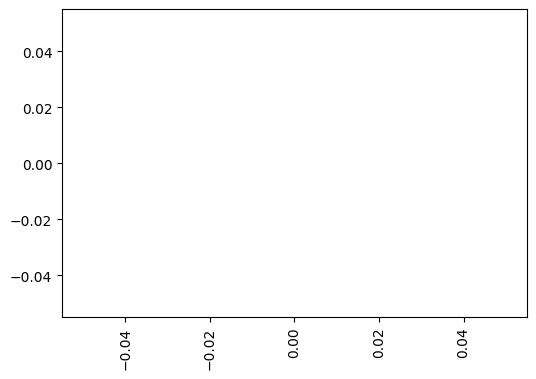

In [ ]:
import matplotlib.pyplot as plt

def plot_goal_status(goals_df):
    status_counts = goals_df['status'].value_counts()
    plt.figure(figsize=(6,4))
    status_counts.plot(kind='bar', color=['orange','green','red'])
    plt.title("Goal Status Distribution")
    plt.xlabel("Status")
    plt.ylabel("Number of Goals")
    plt.show()

plot_goal_status(goals_df)

ValueError: zero-size array to reduction operation fmin which has no identity

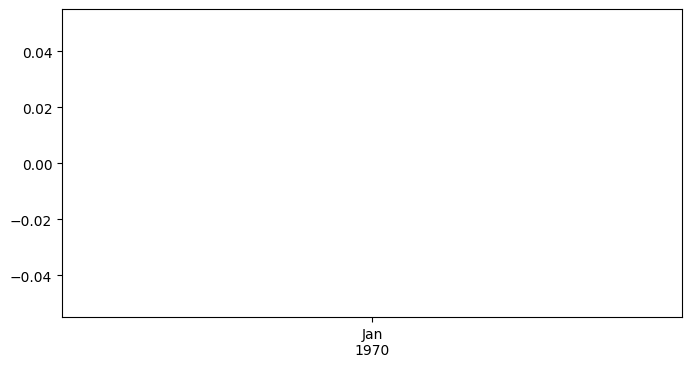

In [ ]:
def plot_entries_over_time(db_path="diary.db"):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("""
    SELECT created_at FROM entries
    """, conn)
    conn.close()

    df['created_at'] = pd.to_datetime(df['created_at'])
    df['month'] = df['created_at'].dt.to_period('M')

    monthly_counts = df['month'].value_counts().sort_index()

    plt.figure(figsize=(8,4))
    monthly_counts.plot(kind='line', marker='o')
    plt.title("Diary Entries Over Time")
    plt.xlabel("Month")
    plt.ylabel("Number of Entries")
    plt.show()

plot_entries_over_time()

In [ ]:
def plot_goal_completion_time(goals_df):
    df = goals_df.dropna(subset=['completed_at']).copy()
    if df.empty:
        print("⚠️ No completed goals yet.")
        return

    df['created_at'] = pd.to_datetime(df['created_at'])
    df['completed_at'] = pd.to_datetime(df['completed_at'])
    df['completion_days'] = (df['completed_at'] - df['created_at']).dt.days

    plt.figure(figsize=(6,4))
    df['completion_days'].hist(bins=10, color="skyblue", edgecolor="black")
    plt.title("Goal Completion Time (days)")
    plt.xlabel("Days to Complete")
    plt.ylabel("Number of Goals")
    plt.show()

plot_goal_completion_time(goals_df)


⚠️ No completed goals yet.
